In [1]:
import gc
gc.collect()

31

In [2]:
y_pred = None  # Clear predictions

In [3]:
#Import liberaries
import pandas as pd
import numpy as np

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from scipy.stats import skew, kurtosis

In [6]:

from xgboost import XGBClassifier

In [7]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
from scipy.stats import randint

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [10]:
from sklearn.pipeline import Pipeline

In [11]:
# Load dataset
df = pd.read_csv("sensor_raw_modified.csv")


In [12]:
#Data exploration
print(df.shape)
print(df.columns)
print(df.dtypes)
df.head()

(1314, 7)
Index(['Target(Class)', 'GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ'], dtype='object')
Target(Class)      int64
GyroX            float64
GyroY            float64
GyroZ            float64
AccX             float64
AccY             float64
AccZ             float64
dtype: object


,Target(Class),GyroX,GyroY,GyroZ,AccX,AccY,AccZ
0,1,-0.923664,3.694656,0.824427,0.162598,-0.086670,-0.969482
1,1,-0.908397,4.534351,0.832061,0.175781,-0.100586,-1.013184
2,1,0.786260,3.969466,0.587786,0.322754,-0.140381,-0.911621
3,1,0.335878,4.564885,-0.251908,0.480225,-0.226807,-0.936768
4,1,3.351145,2.694656,-0.106870,0.426025,-0.253906,-0.950195


In [13]:
df.describe()

,Target(Class),GyroX,GyroY,GyroZ,AccX,AccY,AccZ
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,2.491629,-0.709061,3.502817,2.404843,0.214590,-0.079632,-0.695399
std,1.061838,3.433748,3.516913,11.528901,0.194480,0.183278,41.058925
min,1.000000,-14.946565,-10.351145,-50.259542,-0.284854,-0.793457,-165.157441
25%,2.000000,-2.274809,1.238550,0.480916,0.064026,-0.164490,-1.031372
50%,3.000000,-0.595420,4.080153,1.160305,0.195923,-0.089722,-0.979126
75%,3.000000,0.814885,5.427481,5.068702,0.352112,0.008218,-0.897583
max,4.000000,12.778626,16.793893,45.442748,0.747803,0.768555,172.706929


In [14]:
#Missing value 
df.isnull().sum()

Target(Class)    0
GyroX            0
GyroY            0
GyroZ            0
AccX             0
AccY             0
AccZ             0
dtype: int64

<Axes: title={'center': 'Class Distribution'}, xlabel='Target(Class)'>

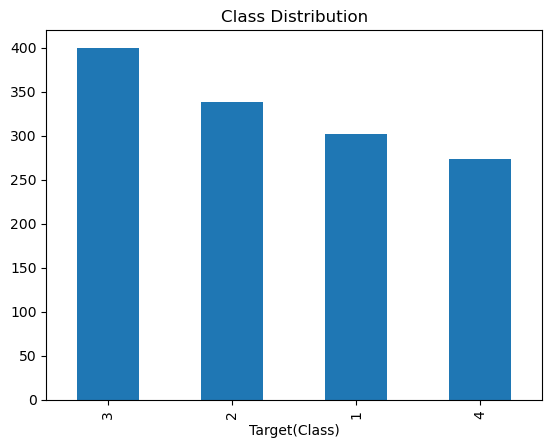

In [15]:
#check for class distribution
df['Target(Class)'].value_counts().plot(kind='bar', title='Class Distribution')

In [16]:
#Data preprocessing 
# Define windowing parameters
#Segment data into fixed-size windows (e.g., 14 seconds → ~28 samples)
window_size = 28
step_size = 14

In [17]:
#Feature engineering

# Sliding window
def feature_engineering(window_size,axes,features):
    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        #print(window)
        row_features = {}
    
        for axis in axes:
            data = window[axis]
            row_features[f'{axis}_mean'] = data.mean()
            row_features[f'{axis}_std'] = data.std()
            row_features[f'{axis}_max'] = data.max()
            row_features[f'{axis}_min'] = data.min()
            row_features[f'{axis}_skew'] = skew(data)
            row_features[f'{axis}_kurtosis'] = kurtosis(data)

        # Assign label as the most frequent in the window
        row_features['Target'] = window['Target(Class)'].mode()[0]
    
        features.append(row_features)

    # Final dataset
    feature_df = pd.DataFrame(features)
    feature_df.to_csv("../data/driver_behavior_features.csv", index=False)
    print(" Feature set saved to 'driver_behavior_features.csv'")

# Axes to extract features from
axes = ['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']
features = []

feature_engineering(window_size,axes,features)



 Feature set saved to 'driver_behavior_features.csv'


In [18]:
# Load your feature dataset
#df = pd.read_csv("../data/FeaturesByWindowSize/sero_features_9.csv")
df = pd.read_csv("../data/driver_behavior_features.csv")
# Prepare features and labels
X = df.drop(columns='Target')
y = df['Target']

In [19]:
print(df['Target'].value_counts())

Target
3    27
1    24
2    23
4    18
Name: count, dtype: int64


In [20]:
# Split into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:

#above causing issue 

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Now both X_train and y_train should have same number of rows
print(X_test.shape, y_test.shape)

(19, 36) (19,)


In [23]:

from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [100, 200]
}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='accuracy')

In [24]:

y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.80      0.62         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       0.75      0.75      0.75         4

    accuracy                           0.74        19
   macro avg       0.81      0.74      0.75        19
weighted avg       0.82      0.74      0.75        19



In [25]:


# Load your dataset (replace with actual path or DataFrame)
# df = pd.read_csv('your_data.csv')

# Example: Assume `X` contains features, and `y` contains labels
# X = df.drop('label', axis=1)
# y = df['label']

# Split into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



# Initialize and train Logistic Regression model
#lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
#lr_model.fit(X_train_scaled, y_train)

# Predict on test data
#y_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
#print("Classification Report:\n", classification_report(y_test, y_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [26]:
#print("Mean Accuracy:", scores.mean())
#Due to  Parameter grid for parameter 'n_estimators' is not iterable or a distribution (value=153)
#X = np.ascontiguousarray(X)
#y = np.ascontiguousarray(y)

In [27]:
# Split into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.model_selection import RandomizedSearchCV
##Hyperparameter Tuning
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017173889E50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001716B492B50>})

In [29]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 7, 'n_estimators': 491}


In [30]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.71      1.00      0.83         5
           2       1.00      0.60      0.75         5
           3       0.80      0.80      0.80         5
           4       0.75      0.75      0.75         4

    accuracy                           0.79        19
   macro avg       0.82      0.79      0.78        19
weighted avg       0.82      0.79      0.79        19



In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7894736842105263


In [33]:
print(y_pred)
print(y_test)

[4 1 1 1 1 4 1 1 3 3 2 2 3 3 4 1 4 3 2]
72    4
6     1
10    1
14    1
90    2
64    4
7     1
91    4
51    3
81    2
34    2
29    2
46    3
41    3
62    3
85    1
74    4
55    3
27    2
Name: Target, dtype: int64


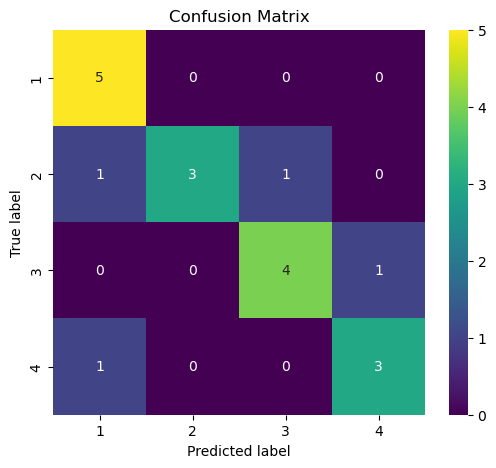

In [34]:
# Create the confusion matrix
# Create the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Explicitly define the class labels: [1, 2, 3, 4]
labels = [1, 2, 3, 4]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='viridis',xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

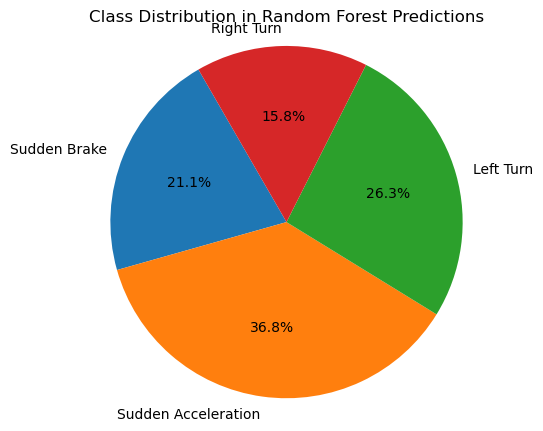

In [35]:
import matplotlib.pyplot as plt
from collections import Counter
#y_pred = [1, 2, 2, 3, 1, 4, 2, 3, 1, 1, 4, 4, 2]

# Count occurrences of each class label
class_counts = Counter(y_pred)

# Map class labels to behavior names
label_map = {
    1: 'Sudden Acceleration',
    2: 'Right Turn',
    3: 'Left Turn',
    4: 'Sudden Brake'
}

labels = [label_map[k] for k in class_counts.keys()]
sizes = list(class_counts.values())

# Plot pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120)
plt.title('Class Distribution in Random Forest Predictions')
plt.axis('equal')
plt.show()

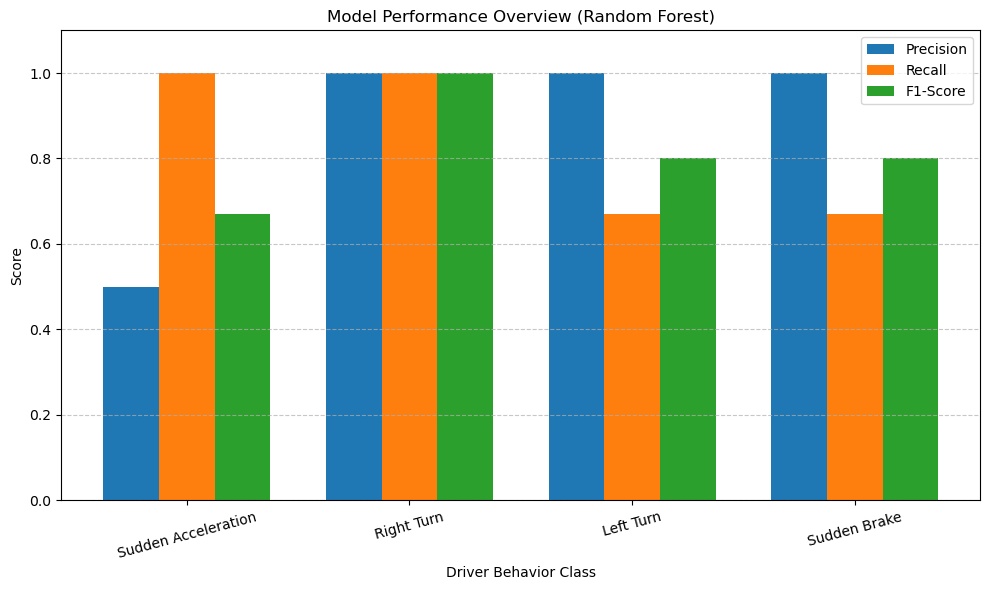

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
classes = ['Sudden Acceleration', 'Right Turn', 'Left Turn', 'Sudden Brake']

# Metrics (replace these with your actual values)
precision = [0.50, 1.00, 1.00, 1.00]
recall    = [1.00, 1.00, 0.67, 0.67]
f1_score  = [0.67, 1.00, 0.80, 0.80]

# Bar width and positions
x = np.arange(len(classes))
width = 0.25

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

# Labeling
plt.xlabel('Driver Behavior Class')
plt.ylabel('Score')
plt.title('Model Performance Overview (Random Forest)')
plt.xticks(x, classes, rotation=15)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [37]:
#####Let's try other classification modules 

#Trying XGB classifier
# Adjust labels to be 0-based
y_train_adj = y_train - 1
y_test_adj = y_test - 1
Xgbclf = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss')
Xgbclf.fit(X_train, y_train_adj)

C:\Users\labuser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:23:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
# Predict and evaluate
y_pred = Xgbclf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         5
           2       0.33      0.40      0.36         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         4

    accuracy                           0.11        19
   macro avg       0.07      0.08      0.07        19
weighted avg       0.09      0.11      0.10        19



C:\Users\labuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\labuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\labuser\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\labuser\anaconda3\Lib\site-packages\sklearn\metr

In [39]:
# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])
# Define hyperparameter space
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 0.01, 0.001]
}
# Grid Search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, y_pred))

Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         5
           2       1.00      0.60      0.75         5
           3       1.00      0.80      0.89         5
           4       1.00      0.50      0.67         4

    accuracy                           0.74        19
   macro avg       0.88      0.73      0.74        19
weighted avg       0.87      0.74      0.75        19



In [40]:

#XGB is underfitted let's try with other classifier
###SVM Classifier 

#from sklearn.svm import SVC

#svcclf = SVC(kernel='rbf', C=1, gamma='scale')
#svcclf.fit(X_train, y_train)

In [41]:
# Predict and evaluate
#y_pred = svcclf.predict(X_test)
#print(classification_report(y_test, y_pred))